In [5]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import statistics
import cv2
from medpy.io import load
from sklearn.decomposition import PCA
import math

In [6]:
# Omitting the posterior tissue in the segmentation
main_path = '../data/Task04_Hippocampus_processed/'
img_files = sorted(os.listdir(main_path+'imagesTr'))
seg_files = sorted(os.listdir(main_path+'labelsTr'))

In [7]:
img = np.load(main_path+'imagesTr/'+img_files[0])
seg = np.load(main_path+'labelsTr/'+seg_files[0])

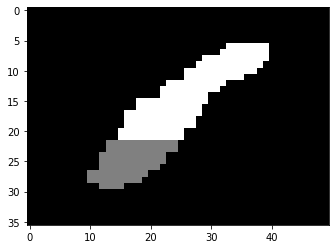

In [16]:
img_slice = img[:,:,5]
seg_slice = seg[:,:,14]
# seg_slice[seg_slice==2] = 0
plt.imshow(img_slice, cmap='gray')
plt.imshow(seg_slice, cmap='gray')
plt.show()

In [17]:
def dotproduct(v1, v2):
    return np.abs(np.dot(v1, v2))

def length(v):
    return np.linalg.norm(v)

def distance(v1, v2):
    return np.linalg.norm(v1-v2)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle1(v1, v2):
  return np.arccos(dotproduct(v1, v2) / (length(v1) * length(v2)))

In [34]:
def get_coords(seg):
    x = []
    y = []
    for i in range(seg.shape[1]):
        for j in range(seg.shape[0]):
            if seg[j][i] != 0:
                x.append(i)
                y.append(seg.shape[0] - j)
    x = np.array(x).reshape(-1,1).T
    y = np.array(y).reshape(-1,1).T
    data = np.concatenate((x,y), axis=0).T
    return data

def get_pca(data):
    pca = PCA(n_components=2)
    pca.fit(data)
    pca_comp = pca.components_
    mean_vec = pca.mean_
    return pca_comp, mean_vec

def get_axes(data, pca_comp, mean_vec):
    axis_length = np.zeros((2,1)).astype('float')
    for i in range(data.shape[0]):
        vec = data[i,:]
        angle_list = []
        for j in range(pca_comp.shape[0]):
            angle_list.append(angle1(vec-mean_vec, pca_comp[j]))

        for index, x in enumerate(angle_list):
            if x < 1.5*math.pi/180:
                dist = distance(mean_vec, vec)
                if dist > axis_length[index][0]:
                    axis_length[index] = dist

    for i in range(axis_length.shape[0]):
        if axis_length[i] == 0.0:
            axis_length[i] = 1
    return axis_length

def inside_outside_new(point, mean, axis_length, pca_comp, angle_vec):
    one = (np.cos(angle_vec)**2/axis_length[0][0]**2 + np.sin(angle_vec)**2/axis_length[1][0]**2)*((point[0]-mean[0]).astype('float'))**2
    two = (np.sin(angle_vec)**2/axis_length[0][0]**2 + np.cos(angle_vec)**2/axis_length[1][0]**2)*((point[1]-mean[1]).astype('float'))**2
    three = 2*(np.cos(angle_vec)*np.sin(angle_vec)*(1/axis_length[0][0]**2 - 1/axis_length[1][0]**2)*((point[0]-mean[0]).astype('float'))*((point[1]-mean[1]).astype('float')))
    if (one+two+three) <= 1:
        return True
    else:
        return False

def get_prior(seg):
    prior_slice = np.zeros_like(seg)
    data = get_coords(seg)
    pca_comp, mean_vec = get_pca(data)
    axis_length = get_axes(data, pca_comp, mean_vec)
    angle_vec = angle1(pca_comp[0], np.array([10,0]))
    for i in range(seg.shape[1]):
        for j in range(seg.shape[0]):
            cond = inside_outside_new(np.array([[i,seg.shape[0] - j]]).reshape(2,-1), mean_vec, axis_length, pca_comp, angle_vec)
            if cond:
                prior_slice[j][i] = 1
    return prior_slice

def get_all_priors(seg_slice):
    num_classes = np.max(seg_slice).astype('int')+1
    for i in range(num_classes):
        if i==0:
            seg = seg_slice.copy()
            full_prior = get_prior(seg)
        if i==1:
            seg = seg_slice.copy()
            seg[seg==2]=0
            left_prior = get_prior(seg)
        if i==2:
            seg = seg_slice.copy()
            seg[seg==1]=0
            right_prior = get_prior(seg)
    left_right_prior = right_prior.copy()
    left_right_prior[left_right_prior==1]=2
    left_right_prior += left_prior
    left_right_prior[left_right_prior==3]=2

    return full_prior, left_prior, right_prior, left_right_prior

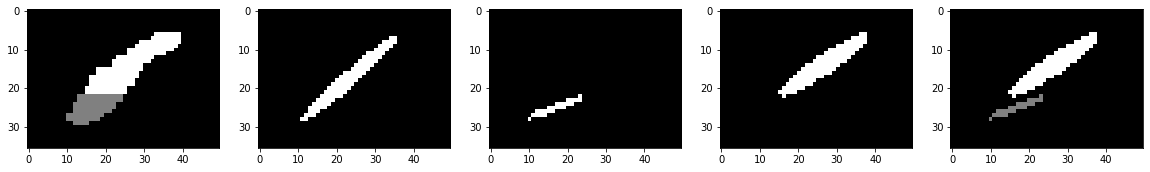

In [37]:
full_prior, left_prior, right_prior, left_right_prior = get_all_priors(seg_slice)
fig = plt.figure(figsize=(20,5))
plt.subplot(1,5,1).imshow(seg_slice, cmap='gray')
plt.subplot(1,5,2).imshow(full_prior, cmap='gray')
plt.subplot(1,5,3).imshow(left_prior, cmap='gray')
plt.subplot(1,5,4).imshow(right_prior, cmap='gray')
plt.subplot(1,5,5).imshow(left_right_prior, cmap='gray')
plt.show()